# Comparative analysis description

# Input data description

In [46]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import inspect
from IPython.display import clear_output
import relegy.embeddings as rle
import relegy.metrics as rlm
import relegy.graphs as rlr
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [35]:
def get_embedding_methods_iterable():
    return filter(lambda x: x[0][:2] != "__", inspect.getmembers(sys.modules['relegy.embeddings']))

In [3]:
node_labels = np.genfromtxt("..\\data\\internet-industry-partnerships\\internet-industry-partnerships.node_labels")
edges = np.genfromtxt("..\\data\\internet-industry-partnerships\\internet-industry-partnerships.edges", delimiter=",").astype(int)
labels1 = node_labels.astype(int)



In [4]:
G1 = nx.Graph()
G1.add_edges_from(edges)
G1 = nx.convert_node_labels_to_integers(G1, first_label=0)

In [5]:
G2, labels2_ = rlr.get_karate_graph()
labels2_ = np.array(labels2_)[:, 1]
labels2 = (labels2_ == 'Mr. Hi').astype(int)

In [6]:
G3, labels3 = rlr.generate_clusters_graph(300, 3, 0.05, 0.5)

In [13]:
labels = [labels1, labels2, labels3]

In [34]:
def get_results_from_all_viable_methods(d, graphs, graph_names=None):
    results = [None] * len(graphs)
    for i, G in enumerate(graphs):
        results_dictionary = {}
        for name, class_handle in get_embedding_methods_iterable():
            info = "Currently processing " + str(name) + ", d: " + str(d)
            if graph_names is not None:
                info += ", graph: " + graph_names[i]
            if not (name == "GCN" or name == "GNN"):
                if name in ["GraphWave", "HOPE", "LINE"]:
                    current_d = d // 2
                else:
                    current_d = d
                print(info)
                if not (name == "HARP"):
                    results_dictionary[name] = class_handle.fast_embed(G, d=current_d)
                    clear_output()
                else:
                    temp_name = "HARP_Deepwalk"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d)
                    temp_name = "HARP_Node2Vec"
                    results_dictionary[temp_name] = class_handle.fast_embed(G, d=current_d, method = "Node2Vec")
                    clear_output()
        results[i] = results_dictionary
    return results

In [12]:
results_d2 = get_results_from_all_viable_methods(d=2, graphs=[G1, G2, G3], graph_names=["G1", "G2", "G3"])

In [36]:
results_d6 = get_results_from_all_viable_methods(d=6, graphs=[G1, G2, G3], graph_names=["G1", "G2", "G3"])

In [51]:
with open("G4_results_d6.p", "wb") as f:
    pickle.dump(results_d6[3], f)

IndexError: list index out of range

In [53]:
embeddings_d2 = {}
for i in range(1, 4):
    with open("G"+str(i)+"_results.p", mode="rb") as f:
        embeddings_d2["G"+str(i)] = pickle.load(f)
embeddings_d6 = {}
for i in range(1, 4):
    with open("G"+str(i)+"_results_d6.p", mode="rb") as f:
        embeddings_d6["G"+str(i)] = pickle.load(f)

In [67]:
reg_results_train_d2 = {"G1": {}, "G2":{}, "G3":{}}
reg_results_test_d2 = {"G1": {}, "G2":{}, "G3":{}}
for j in range(1, 4):
    names = embeddings_d2['G'+str(j)].keys()
    labels_cur = labels[j-1]
    reg_results = {}
    for i, name in enumerate(names):
        Z = embeddings_d2['G'+str(j)][name]
        X_train, X_test, y_train, y_test = train_test_split(Z, labels_cur, random_state=0)
        logreg = LogisticRegression(max_iter=400)
        logreg.fit(X_train, y_train)
        reg_results_train_d2["G"+str(j)][name] = logreg.score(X_train, y_train)
        reg_results_test_d2["G"+str(j)][name] = logreg.score(X_test, y_test)

In [72]:
reg_results_train_d6 = {"G1": {}, "G2":{}, "G3":{}}
reg_results_test_d6 = {"G1": {}, "G2":{}, "G3":{}}
for j in range(1, 4):
    names = embeddings_d6['G'+str(j)].keys()
    labels_cur = labels[j-1]
    reg_results = {}
    for i, name in enumerate(names):
        Z = embeddings_d6['G'+str(j)][name]
        X_train, X_test, y_train, y_test = train_test_split(Z, labels_cur, random_state=0)
        logreg = LogisticRegression(max_iter=800)
        logreg.fit(X_train, y_train)
        reg_results_train_d6["G"+str(j)][name] = logreg.score(X_train, y_train)
        reg_results_test_d6["G"+str(j)][name] = logreg.score(X_test, y_test)

In [57]:
G1_res_d2 = np.array(list(reg_results_test_d2["G1"].items()))
G2_res_d2 = np.array(list(reg_results_test_d2["G2"].items()))
G3_res_d2 = np.array(list(reg_results_test_d2["G3"].items()))

In [74]:
G1_res_d6 = np.array(list(reg_results_test_d6["G1"].items()))
G2_res_d6 = np.array(list(reg_results_test_d6["G2"].items()))
G3_res_d6 = np.array(list(reg_results_test_d6["G3"].items()))

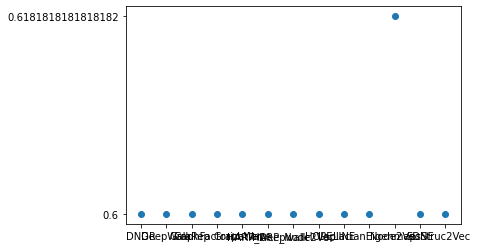

In [45]:
plt.scatter(G1_res_d2[:, 0], G1_res_d2[:, 1])

In [89]:
np.round(G1_res_d2[:, 1].astype(np.float32), 3)

array([0.6  , 0.618, 0.6  , 0.6  , 0.6  , 0.6  , 0.6  , 0.6  , 0.582,
       0.6  , 0.6  , 0.6  , 0.6  ], dtype=float32)

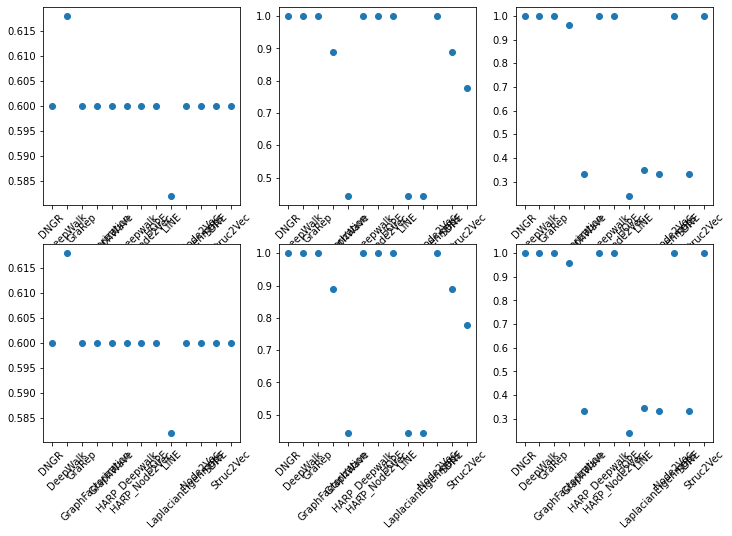

In [105]:
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 12, 8
fig, axs = plt.subplots(2, 3)
plt.setp(axs[0, 0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[0, 1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[0, 2].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[1, 0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[1, 1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[1, 2].xaxis.get_majorticklabels(), rotation=45)
axs[0, 0].scatter(G1_res_d2[:, 0], np.round(G1_res_d2[:, 1].astype(np.float32), 3))
axs[0, 1].scatter(G2_res_d2[:, 0], np.round(G2_res_d2[:, 1].astype(np.float32), 3))
axs[0, 2].scatter(G3_res_d2[:, 0], np.round(G3_res_d2[:, 1].astype(np.float32), 3))
axs[1, 0].scatter(G1_res_d6[:, 0], np.round(G1_res_d6[:, 1].astype(np.float32), 3))
axs[1, 1].scatter(G2_res_d6[:, 0], np.round(G2_res_d6[:, 1].astype(np.float32), 3))
axs[1, 2].scatter(G3_res_d6[:, 0], np.round(G3_res_d6[:, 1].astype(np.float32), 3))
plt.show()